In [9]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

In [10]:
%store -r final_df
final_df

,Temp,Humidity,Wind,Rain,ISI,Actual Fire
0,8.2,51.0,6.7,0.0,5.1,0.0
1,18.0,33.0,0.9,0.0,6.7,0.0
2,14.6,33.0,1.3,0.0,6.7,0.0
3,8.3,97.0,4.0,0.2,9.0,0.0
4,11.4,99.0,1.8,0.0,9.6,0.0
...,...,...,...,...,...,...
756,30.0,65.0,14.0,0.0,4.5,1.0
757,28.0,87.0,15.0,4.4,0.1,0.0
758,27.0,87.0,29.0,0.5,0.4,0.0
759,24.0,54.0,18.0,0.1,1.7,0.0


In [11]:
final_df_remove_outliers = final_df[(np.abs(zscore(final_df)) < 3).all(axis=1)]

final_df.index.difference(final_df_remove_outliers.index)

Int64Index([ 11,  22, 266, 499, 519, 608, 609, 610, 621, 622, 633, 640, 655,
            656, 657, 676, 735, 736, 757, 758],
           dtype='int64')

In [12]:
# Normalize columns as to not deal with different units
final_df_remove_outliers = final_df_remove_outliers / final_df_remove_outliers.max()

## Building The Model

Outline of building model:
split training and testing sets
create model

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.layers import Dense, Input
import tensorflow_addons as tfa

In [16]:
classification_x = final_df_remove_outliers.iloc[:,: -2].values
classification_y = final_df_remove_outliers.iloc[:,-1 :].values

In [17]:
print(classification_x.shape, classification_y.shape)

(740, 4) (740, 1)


In [18]:
regression_x = final_df_remove_outliers.iloc[:,: -2].values
regression_y = final_df_remove_outliers.iloc[:,-2:-1].values

In [19]:
print(regression_x.shape, regression_y.shape)

(740, 4) (740, 1)


In [20]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(classification_x,classification_y, test_size=0.33, random_state=0)
X_train_rg, X_test_rg, y_train_rg, y_test_rg = train_test_split(regression_x,regression_y, test_size=0.33, random_state=0)

In [31]:
# Build the model with Functional API
# Look at https://keras.io/guides/functional_api/
inputs = Input(shape=(4,))
layer_class = Dense(4,input_shape=(4,), kernel_initializer='normal',activation='sigmoid',name='layer1')(inputs)
layer_class = Dense(2, kernel_initializer='normal',activation='sigmoid',name='layer2')(layer_class)
output_class = Dense(1, kernel_initializer='normal', activation='softmax',name='classification')(layer_class)

# inputs_reg = Input(shape=(7,))
layer_reg = Dense(4,input_shape=(4,),activation='relu',name='layer3')(inputs)
output_reg = Dense(1, activation='linear',name='regression')(layer_reg)

c_model = Model(inputs=inputs, outputs=[output_class,output_reg],name="double_model")

inputs_reg = Input(shape=(7,))
layer_reg = Dense(7,input_shape=(7,),activation='relu')(inputs_reg)
output_reg = Dense(1, activation='linear')(layer_reg)
reg_model = Model(inputs=inputs_reg, outputs=output_reg,name="single_model")

from keras import metrics
reg_model.compile(
    loss= 'mse',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics= 'accuracy'
)

checkpoint = MergeMetrics()
reg_model.fit(x=regression_x, y=regression_y, epochs = 10)

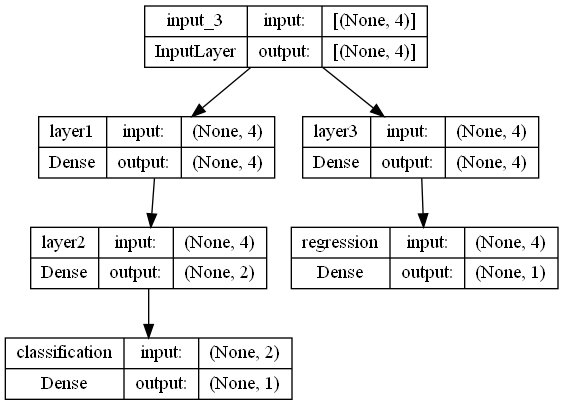

In [32]:
keras.utils.plot_model(c_model, "double_model.png", show_shapes=True)

In [33]:
# Compile the model 
from keras import metrics
c_model.compile(
    loss=['binary_crossentropy', 'mse'],
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy", 'mse']
)

In [34]:
from keras.callbacks import Callback
class MergeMetrics(Callback):

    def __init__(self,**kargs):
        super(MergeMetrics,self).__init__(**kargs)

    def on_epoch_begin(self,epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        logs['loss'] = logs["classification_loss"]+logs['regression_loss']
        logs['total_accuracy'] = logs["classification_sparse_categorical_accuracy"]+logs['regression_mse']

In [35]:
checkpoint = MergeMetrics()
history = c_model.fit(x=regression_x,y=[classification_y,regression_y], verbose=0, epochs = 10,callbacks=[checkpoint])
total_loss = history.history['loss']
total_accuracy = history.history['total_accuracy']
class_loss = history.history["classification_loss"]
reg_loss = history.history['regression_loss']
class_acc = history.history["classification_sparse_categorical_accuracy"]
reg_acc = history.history['regression_mse']
loss_acc_dict = {'Class Loss':class_loss,'Class Acc':class_acc,'Reg Loss': reg_loss, 'Reg Acc': reg_acc, 'Total Loss':total_loss, 'Total Acc':total_accuracy}
loss_acc_df = pd.DataFrame(loss_acc_dict)
loss_acc_df

,Class Loss,Class Acc,Reg Loss,Reg Acc,Total Loss,Total Acc
0,0.695764,0.454054,0.255420,0.255420,0.951184,0.709474
1,0.695645,0.454054,0.220491,0.220491,0.916136,0.674545
2,0.695512,0.454054,0.191622,0.191622,0.887134,0.645676
3,0.695357,0.454054,0.167262,0.167262,0.862619,0.621316
4,0.695245,0.454054,0.147420,0.147420,0.842665,0.601474
5,0.695134,0.454054,0.131262,0.131262,0.826396,0.585316
6,0.695010,0.454054,0.117790,0.117790,0.812800,0.571844
7,0.694905,0.454054,0.106380,0.106380,0.801286,0.560434
8,0.694764,0.454054,0.097401,0.097401,0.792164,0.551455
9,0.694645,0.454054,0.089799,0.089799,0.784443,0.543853
